In [334]:
import numpy as np
import math
from collections import Counter
from typing import NamedTuple
from pprint import pprint
import sklearn.metrics
import scipy.stats

rng = np.random.default_rng()

Instructions: https://work.caltech.edu/homework/hw2.pdf

Answers: http://work.caltech.edu/homework/hw2_sol.pdf

# Hoeffding Inequality

# 1.

In [103]:
def flippedy_flip(n_coins, n_flips, n_experiments, verbose=False): 
    ν_1s = []
    ν_rands = []
    ν_mins = []
    for experiment in range(n_experiments):
        heads = Counter()
        for coin in range(n_coins):
            for flip in range(n_flips):
                result = rng.choice([False, True])
                if result == True:
                    heads[coin] += 1
        if verbose:
            print(f"heads counter for experiment run {experiment}: {heads}")
        c_1 = 0
        c_rand = rng.choice(range(n_coin))
        if verbose:
            print(f"picked coin c_rand: {c_rand} at random from {n_coins} coins")
        c_min = heads.most_common()[:-2:-1][0][0]
        if verbose:
            print(f"picked coin c_min: {c_min} with frequency: {heads[c_min]}")
        ν_1 = heads[c_1] / n_flips
        
        ν_1s.append(ν_1)
        ν_rand = heads[c_rand] / n_flips
        ν_rands.append(ν_rand)
        ν_min = heads[c_min] / n_flips
        ν_mins.append(ν_min)
        if verbose:
            print(f"Fractions: ν_1: {ν_1}, ν_rand: {ν_rand}, ν_min: {ν_min}")

    return {
        "ν_1s": ν_1s,
        "ν_rands": ν_rands,
        "ν_mins": ν_mins
    }

n_coins = 1000
n_flips = 10
n_experiments = 1000

result = flippedy_flip(n_coins = n_coins, n_flips = n_flips, n_experiments = n_experiments, verbose=False)
np.array(result["ν_mins"]).mean()

0.10000000000000002

Definitely not running this 100,000 times with this efficiency -.- but it looks super close to 0.1, unlikely to change.

My answer: <font color="red">c</font>

That's wrong : )

Bug or does it actually change when ran more often?

Looks like I just bugged it: I'm not counting the zero head frequency at all since that never gets created in the counter 🙈 let's fix that:

In [104]:
def flippedy_flip(n_coins, n_flips, n_experiments, verbose=False): 
    ν_1s = []
    ν_rands = []
    ν_mins = []
    for experiment in range(n_experiments):
        heads = Counter()
        for coin in range(n_coins):
            heads[coin] = 0
            for flip in range(n_flips):
                result = rng.choice([False, True])
                if result == True:
                    heads[coin] += 1
        if verbose:
            print(f"heads counter for experiment run {experiment}: {heads}")
        c_1 = 0
        c_rand = rng.choice(range(n_coin))
        if verbose:
            print(f"picked coin c_rand: {c_rand} at random from {n_coins} coins")
        c_min = heads.most_common()[:-2:-1][0][0]
        if verbose:
            print(f"picked coin c_min: {c_min} with frequency: {heads[c_min]}")
        ν_1 = heads[c_1] / n_flips
        
        ν_1s.append(ν_1)
        ν_rand = heads[c_rand] / n_flips
        ν_rands.append(ν_rand)
        ν_min = heads[c_min] / n_flips
        ν_mins.append(ν_min)
        if verbose:
            print(f"Fractions: ν_1: {ν_1}, ν_rand: {ν_rand}, ν_min: {ν_min}")

    return {
        "ν_1s": ν_1s,
        "ν_rands": ν_rands,
        "ν_mins": ν_mins
    }

n_coins = 1000
n_flips = 10
n_experiments = 1000

result = flippedy_flip(n_coins = n_coins, n_flips = n_flips, n_experiments = n_experiments, verbose=False)
np.array(result["ν_mins"]).mean()

0.0359

That's better : )

Let's also make it faster so we can actually do the 100,000 experiment runs in reasonable time!

Vectorizing the loops for speeeeeed:

In [121]:
def flippedy_flip_fast(n_coins, n_flips, n_experiments):
    counts = rng.binomial(n_flips, 0.5, size=(n_experiments, n_coins))

    ν_1s = counts[:, 0] / n_flips
    
    c_rands = rng.integers(0, n_coins, size=n_experiments)
    ν_rands = counts[np.arange(n_experiments), c_rands] / n_flips

    c_min = counts.min(axis=1)
    ν_mins = c_min / n_flips
    
    return {
        "ν_1s": ν_1s,
        "ν_rands": ν_rands,
        "ν_mins": ν_mins
    }

Loop impl timing for a 1000 runs:

In [136]:
%%time

n_coins = 1000
n_flips = 10
n_experiments = 1000

result = flippedy_flip(n_coins = n_coins, n_flips = n_flips, n_experiments = n_experiments, verbose=False)
np.array(result["ν_mins"]).mean()

CPU times: user 1min 3s, sys: 370 ms, total: 1min 4s
Wall time: 1min 3s


0.037399999999999996

Vectorized impl timing for a 1000 runs:

In [124]:
%%time

n_coins = 1000
n_flips = 10
n_experiments = 1000

result = flippedy_flip_fast(n_coins = n_coins, n_flips = n_flips, n_experiments = n_experiments)
np.array(result["ν_mins"]).mean()

CPU times: user 33.5 ms, sys: 999 μs, total: 34.5 ms
Wall time: 33.3 ms


0.03989999999999999

Sliiiight speedup of x2000 ;)

Now we should be ready!

In [135]:
n_coins = 1000
n_flips = 10
n_experiments = 100_000

result = flippedy_flip_fast(n_coins = n_coins, n_flips = n_flips, n_experiments = n_experiments)
np.array(result["ν_mins"]).mean()

0.037847

This is now indeed closest to [b].

My answer: <font color="green">b</font>

# 2.

Before digging into this, my assumption would be that c_1 and c_rand should both satisfy single-bin Hoeffding, since there's no decision making involved and we're simply picking at random.

So my answer would we [d], but let's verify!

In [129]:
result

{'ν_1s': array([0.4, 0.4, 0.7, ..., 0.7, 0.7, 0.3]),
 'ν_rands': array([0.5, 0.2, 0.4, ..., 0.6, 0.2, 0.5]),
 'ν_mins': array([0. , 0.1, 0.1, ..., 0. , 0.1, 0. ])}

In [137]:
# μ in our case is known as 0.5.
μ = 0.5

ν_1 = np.array(result["ν_1s"]).mean()

0.4995

N for the single-bin Hoeffding would be 1000, since we flip 1000 coins at a time and then look at the distributions

In [162]:
N = n_coins

P[|ν-μ| > ϵ] <= 2 * e^(-2*ϵ²*N)

In [163]:
ϵ_1 = μ - ν_1
ϵ_1


0.0005000000000000004

ϵ_1 is our probability of a bad event, and it needs to be smaller than what the Hoeffding Inequality predicts for 100_000_000 runs:

In [164]:
hoeffding_ϵ_1 = 2 * math.exp(-2 * (ϵ_1 ** 2) * N)
hoeffding_ϵ_1

1.9990002499583386

In [165]:
ϵ_1 <= hoeffding_ε_1

True

Now `c_rand` should be valid as well I think: 

In [167]:
ν_rand = np.array(result["ν_rands"]).mean()
ϵ_rand = μ - ν_rand
hoeffding_ϵ_rand = 2 * math.exp(-2 * (ϵ_rand ** 2) * N)

ϵ_rand <= hoeffding_ε_rand

True

✅

Now I **think** `c_min` should be false, since we're deliberately picking the minimum in each experiment, and therefore vanilla Hoeffding shouldn't apply since we have multiple bins:

In [172]:
ν_min = np.array(result["ν_mins"]).mean()
print(f"Our sampled frequency of ν_min: {ν_min}")
ϵ_min = μ - ν_min
print(f"ϵ_min: {ϵ_min}")
hoeffding_ϵ_min = 2 * math.exp(-2 * (ϵ_min ** 2) * N)
print(f"hoeffding bound prediction: {hoeffding_ϵ_min}")

Our sampled frequency of ν_min: 0.037399999999999996
ϵ_min: 0.4626
hoeffding bound prediction: 2.655026079551988e-186


That's a gigantic difference, so indeed:

In [173]:
ϵ_min <= hoeffding_ϵ_min

False

As predicted and now verified, my answer is:  <font color="green">d</font>

# Error and Noise

In [ ]:
TODO after watching Vid4

# Linear Regression

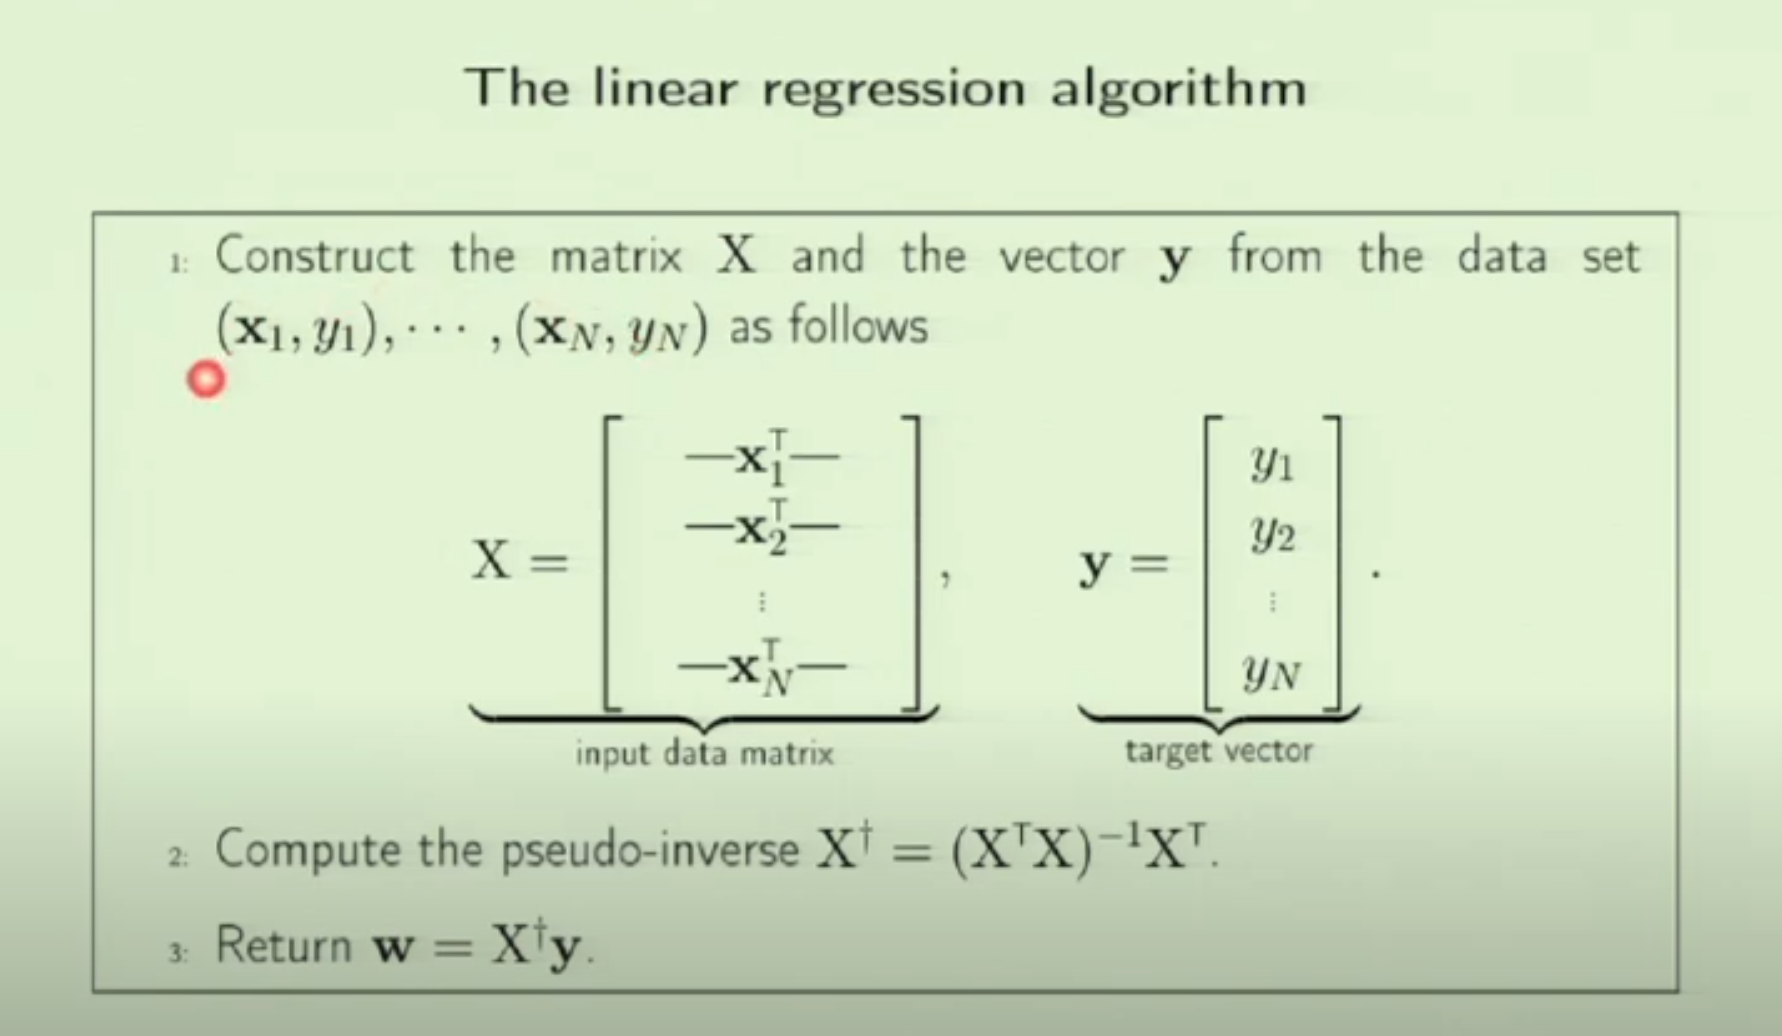

In [215]:
class Point(NamedTuple):
    x: float
    y: float


def run_linreg(n, n_experiments, verbose=False):
    ws = []
    e_ins = []
    for experiment in range(n_experiments):
        if verbose:
            print(f"Experiment #: {experiment}")
        # Pick a new target function f
        p1 = Point(*np.random.uniform(-1, 1, size=2))
        p2 = Point(*np.random.uniform(-1, 1, size=2))
        m = (p2.y - p1.y) / (p2.x - p1.x)
        b = p1.y - m * p1.x
    
        def classify_point(x, y):
            fxy = y - m * x - b
            return 1 if fxy > 0 else -1
        
        # Pick N random training points
        x_train = np.random.uniform(-1, 1, size=(n, 2))
        # Augment with constant (instead of using a bias)
        x_train = np.hstack([x_train, np.ones((n, 1))])
        assert x_train.shape == (n, 3)
        y_train = [classify_point(p[0], p[1]) for p in x_train] 

        w = np.linalg.pinv(x_train) @ y_train
        assert w.shape == (3,)
        if verbose:
            print(f"Linear Regression found weights: {w}")
        ws.append(w)

        y_pred = x_train @ w
        e_in = sklearn.metrics.mean_squared_error(y_train, y_pred)
        e_ins.append(e_in)
    
    return {
        "ws": ws,
        "e_ins": e_ins,
    }

run_linreg(1000, 10, True)

Experiment #: 0
Linear Regression found weights: [-0.61494779  0.58482593  0.67999814]
Experiment #: 1
Linear Regression found weights: [ 0.7175396   0.78013766 -0.56497598]
Experiment #: 2
Linear Regression found weights: [0.9684924  0.84098694 0.29234633]
Experiment #: 3
Linear Regression found weights: [0.39738591 0.34614677 0.82730251]
Experiment #: 4
Linear Regression found weights: [-0.8877261   0.34089609  0.60372359]
Experiment #: 5
Linear Regression found weights: [-0.69621032  1.24429449 -0.02194934]
Experiment #: 6
Linear Regression found weights: [-1.36947231  0.12931556  0.25630812]
Experiment #: 7
Linear Regression found weights: [ 0.18761883  0.5888906  -0.78620033]
Experiment #: 8
Linear Regression found weights: [ 0.70629372  0.67491625 -0.5879826 ]
Experiment #: 9
Linear Regression found weights: [0.45291467 0.63584106 0.71694384]


{'ws': [array([-0.61494779,  0.58482593,  0.67999814]),
  array([ 0.7175396 ,  0.78013766, -0.56497598]),
  array([0.9684924 , 0.84098694, 0.29234633]),
  array([0.39738591, 0.34614677, 0.82730251]),
  array([-0.8877261 ,  0.34089609,  0.60372359]),
  array([-0.69621032,  1.24429449, -0.02194934]),
  array([-1.36947231,  0.12931556,  0.25630812]),
  array([ 0.18761883,  0.5888906 , -0.78620033]),
  array([ 0.70629372,  0.67491625, -0.5879826 ]),
  array([0.45291467, 0.63584106, 0.71694384])],
 'e_ins': [0.3093592332572854,
  0.32990240743974814,
  0.32863461072511074,
  0.22448858488096676,
  0.323687020040287,
  0.315966442101564,
  0.28852189902976777,
  0.2737569040613069,
  0.3363941267475905,
  0.29167101346918345]}

# 5.

In [218]:
n = 100
n_experiments = 1000

result = run_linreg(n = n, n_experiments = n_experiments, verbose= False)
np.array(result["e_ins"]).mean()

0.291544461947015

This is somewhat in between [d] and [e] but slightly closer to [d]:

My answer: <font color="red">d</font>

Wrong again = ) what happened?

Hmm, likely I need to apply the classification version of linear regression and already map the answer to +1/-1, even though that's not really too clear from the problem description?

Let's try that:

In [228]:
class Point(NamedTuple):
    x: float
    y: float


def run_linreg_for_classification(n, n_experiments, verbose=False):
    ws = []
    e_ins = []
    for experiment in range(n_experiments):
        if verbose:
            print(f"Experiment #: {experiment}")
        # Pick a new target function f
        p1 = Point(*np.random.uniform(-1, 1, size=2))
        p2 = Point(*np.random.uniform(-1, 1, size=2))
        m = (p2.y - p1.y) / (p2.x - p1.x)
        b = p1.y - m * p1.x
    
        def classify_point(x, y):
            fxy = y - m * x - b
            return 1 if fxy > 0 else -1
        
        # Pick N random training points
        x_train = np.random.uniform(-1, 1, size=(n, 2))
        # Augment with constant (instead of using a bias)
        x_train = np.hstack([x_train, np.ones((n, 1))])
        assert x_train.shape == (n, 3)
        y_train = [classify_point(p[0], p[1]) for p in x_train] 

        w = np.linalg.pinv(x_train) @ y_train
        assert w.shape == (3,)
        if verbose:
            print(f"Linear Regression found weights: {w}")
        ws.append(w)


        if verbose:
            print(f"Trying to \"learn\" y_train: {y_train}")
        y_pred = x_train @ w
        if verbose:
            print(f"Direct linear regression predictions: {y_pred}")
        y_pred_class = np.sign(y_pred)
        if verbose:
            print(f"Signed linear regression predictions for classification: {y_pred_class}")
        e_in = sklearn.metrics.mean_squared_error(y_train, y_pred_class)
        if verbose:
            print(f"E_in for experiment {experiment}: {e_in}")
        e_ins.append(e_in)
    
    return {
        "ws": ws,
        "e_ins": e_ins,
    }

run_linreg_for_classification(10, 5, True)

Experiment #: 0
Linear Regression found weights: [1.02248614 1.15694652 0.09445975]
Trying to "learn" y_train: [-1, 1, 1, -1, 1, -1, 1, -1, 1, -1]
Direct linear regression predictions: [-0.2375929   0.45595583  0.37947862 -1.24619929  0.75006675 -0.91543871
  1.63735673 -0.19886224  0.33477625 -0.95954104]
Signed linear regression predictions for classification: [-1.  1.  1. -1.  1. -1.  1. -1.  1. -1.]
E_in for experiment 0: 0.0
Experiment #: 1
Linear Regression found weights: [ 0.91337903  0.34899901 -0.43764159]
Trying to "learn" y_train: [-1, -1, -1, 1, -1, -1, -1, -1, -1, 1]
Direct linear regression predictions: [-1.51000952 -0.82813422 -1.54667648  0.40211512 -0.29711252 -0.87799328
 -0.77817061 -0.4678689  -0.55121089  0.45506132]
Signed linear regression predictions for classification: [-1. -1. -1.  1. -1. -1. -1. -1. -1.  1.]
E_in for experiment 1: 0.0
Experiment #: 2
Linear Regression found weights: [ 0.71543053 -0.42346207  0.70390313]
Trying to "learn" y_train: [1, 1, -1, -

{'ws': [array([1.02248614, 1.15694652, 0.09445975]),
  array([ 0.91337903,  0.34899901, -0.43764159]),
  array([ 0.71543053, -0.42346207,  0.70390313]),
  array([ 1.16542021,  0.75193829, -0.04924438]),
  array([ 0.58714714,  1.10760351, -0.44809784])],
 'e_ins': [0.0, 0.0, 0.4, 0.4, 0.4]}

In [223]:
n = 100
n_experiments = 1000

result = run_linreg_for_classification(n = n, n_experiments = n_experiments, verbose= False)
np.array(result["e_ins"]).mean()

0.15524000000000002

Still closer to [d] 🤔

Maybe the mean squared error definitions are different?
Let's implement it ourselves.


In [242]:
n = 2
x_train = [[1, 1, 2, 3],[1, 5, 6, 7]]
y_train = [[1, -1, 1, -1], [-1, 1, 1, -1]]

w = np.linalg.pinv(x_train) @ y_train
y_pred = x_train @ w

e_in_sklearn = sklearn.metrics.mean_squared_error(y_train, y_pred)
print(e_in_sklearn)

def squared_error(y_trains, y_preds, n=2):
    errs = []
    for (y_train,y_pred) in zip(y_trains,y_preds):
        err = (y_train - y_pred) ** 2
        errs.append(err)
    return np.array(sum(errs) / n).mean()
    
e_self_impl = squared_error(y_train, y_pred)
print(e_self_impl)


5.053640174072107e-31
5.053640174072107e-31


Hmm, no obvious difference there.

Re-reading the problem, it seems I should be defining `e_in` as the fraction of in-sample points with got classified incorrectly, NOT use MSE:

In [243]:
class Point(NamedTuple):
    x: float
    y: float


def run_linreg_for_classification(n, n_experiments, verbose=False):
    ws = []
    e_ins = []
    for experiment in range(n_experiments):
        if verbose:
            print(f"Experiment #: {experiment}")
        # Pick a new target function f
        p1 = Point(*np.random.uniform(-1, 1, size=2))
        p2 = Point(*np.random.uniform(-1, 1, size=2))
        m = (p2.y - p1.y) / (p2.x - p1.x)
        b = p1.y - m * p1.x
    
        def classify_point(x, y):
            fxy = y - m * x - b
            return 1 if fxy > 0 else -1
        
        # Pick N random training points
        x_train = np.random.uniform(-1, 1, size=(n, 2))
        # Augment with constant (instead of using a bias)
        x_train = np.hstack([x_train, np.ones((n, 1))])
        assert x_train.shape == (n, 3)
        y_train = [classify_point(p[0], p[1]) for p in x_train] 

        w = np.linalg.pinv(x_train) @ y_train
        assert w.shape == (3,)
        if verbose:
            print(f"Linear Regression found weights: {w}")
        ws.append(w)


        if verbose:
            print(f"Trying to \"learn\" y_train: {y_train}")
        y_pred = x_train @ w
        if verbose:
            print(f"Direct linear regression predictions: {y_pred}")
        y_pred_class = np.sign(y_pred)
        if verbose:
            print(f"Signed linear regression predictions for classification: {y_pred_class}")
        e_in = np.mean(y_pred_class != y_train)
        if verbose:
            print(f"E_in for experiment {experiment}: {e_in}")
        e_ins.append(e_in)
    
    return {
        "ws": ws,
        "e_ins": e_ins,
    }

run_linreg_for_classification(10, 5, True)

Experiment #: 0
Linear Regression found weights: [ 2.77555756e-17 -3.88578059e-16  1.00000000e+00]
Trying to "learn" y_train: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Direct linear regression predictions: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Signed linear regression predictions for classification: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
E_in for experiment 0: 0.0
Experiment #: 1
Linear Regression found weights: [ 2.15913316  0.77023039 -0.36566004]
Trying to "learn" y_train: [-1, 1, -1, -1, -1, 1, -1, 1, -1, -1]
Direct linear regression predictions: [-1.4390762   0.2899712  -0.50644587 -0.15388216 -0.58252302  0.77427952
 -1.34065135  0.91054881 -0.82856721 -1.12365372]
Signed linear regression predictions for classification: [-1.  1. -1. -1. -1.  1. -1.  1. -1. -1.]
E_in for experiment 1: 0.0
Experiment #: 2
Linear Regression found weights: [-0.39835337  0.54887026 -0.65118105]
Trying to "learn" y_train: [-1, -1, -1, -1, -1, -1, 1, -1, -1, -1]
Direct linear regression predictions: [-1.27743692 -0.31684458 -

{'ws': [array([ 2.77555756e-17, -3.88578059e-16,  1.00000000e+00]),
  array([ 2.15913316,  0.77023039, -0.36566004]),
  array([-0.39835337,  0.54887026, -0.65118105]),
  array([-0.66655026,  0.19573523, -0.70283655]),
  array([-0.52233445,  1.41192674, -0.41197818])],
 'e_ins': [0.0, 0.0, 0.1, 0.1, 0.0]}

In [245]:
n = 100
n_experiments = 1000

result = run_linreg_for_classification(n = n, n_experiments = n_experiments, verbose= False)
np.array(result["e_ins"]).mean()

0.04094

Corrected answer: <font color="green">c</font>

# 6.

In [250]:
def run_linreg_with_eout_estimates(n, n_experiments, n_eout_points, verbose=False):
    e_out_ests = []
    ws = []
    for experiment in range(n_experiments):
        if verbose:
            print(f"Experiment #: {experiment}")
        # Pick a new target function f
        p1 = Point(*np.random.uniform(-1, 1, size=2))
        p2 = Point(*np.random.uniform(-1, 1, size=2))
        m = (p2.y - p1.y) / (p2.x - p1.x)
        b = p1.y - m * p1.x
    
        def classify_point(x, y):
            fxy = y - m * x - b
            return 1 if fxy > 0 else -1
        
        # Pick N random training points
        x_train = np.random.uniform(-1, 1, size=(n, 2))
        # Augment with constant (instead of using a bias)
        x_train = np.hstack([x_train, np.ones((n, 1))])
        assert x_train.shape == (n, 3)
        y_train = [classify_point(p[0], p[1]) for p in x_train] 

        w = np.linalg.pinv(x_train) @ y_train
        assert w.shape == (3,)
        if verbose:
            print(f"Linear Regression found weights: {w}")

        if verbose:
            print(f"Trying to \"learn\" y_train: {y_train}")
        y_pred = x_train @ w
        if verbose:
            print(f"Direct linear regression predictions: {y_pred}")
        y_pred_class = np.sign(y_pred)
        if verbose:
            print(f"Signed linear regression predictions for classification: {y_pred_class}")
        e_in = np.mean(y_pred_class != y_train)
        if verbose:
            print(f"E_in for experiment {experiment}: {e_in}")

        x_est = np.random.uniform(-1, 1, size=(n_eout_points,2))
        x_est = np.hstack([x_est, np.ones((n_eout_points, 1))])
        y_est = [classify_point(p[0], p[1]) for p in x_est]
        y_est_pred = np.sign(x_est @ w)
        e_out_est = sklearn.metrics.zero_one_loss(y_est, y_est_pred)
        e_out_ests.append(e_out_est)
    
    return {
        "e_out_ests": e_out_ests,
        "ws": ws
    }

run_linreg_with_eout_estimates(10, 5, 5, True)

Experiment #: 0
Linear Regression found weights: [ 1.98790702  0.39947902 -0.20922599]
Trying to "learn" y_train: [1, -1, -1, 1, -1, 1, -1, 1, -1, -1]
Direct linear regression predictions: [ 0.12194679 -1.12457193 -0.8950298   1.63500129 -0.54561129  0.4068715
 -1.19852412  0.54126562 -0.36919233 -0.57215573]
Signed linear regression predictions for classification: [ 1. -1. -1.  1. -1.  1. -1.  1. -1. -1.]
E_in for experiment 0: 0.0
Experiment #: 1
Linear Regression found weights: [-1.10231383  0.51184425  0.66831519]
Trying to "learn" y_train: [1, 1, 1, 1, -1, 1, 1, -1, 1, 1]
Direct linear regression predictions: [ 1.11544128 -0.005673    0.45070561  1.21972088 -0.03152596  1.27903027
  0.7471677  -0.03802215  0.95530742  0.30784793]
Signed linear regression predictions for classification: [ 1. -1.  1.  1. -1.  1.  1. -1.  1.  1.]
E_in for experiment 1: 0.1
Experiment #: 2
Linear Regression found weights: [-2.17028228  0.7288137  -1.30140819]
Trying to "learn" y_train: [1, -1, -1, 1, 

{'e_out_ests': [0.0, 0.19999999999999996, 0.0, 0.19999999999999996, 0.4]}

In [256]:
n = 100
n_experiments = 1000
n_eout_points = 1000

result = run_linreg_with_eout_estimates(n=n, n_experiments=n_experiments, n_eout_points=n_eout_points, verbose=False)
np.array(result["e_out_ests"]).mean()

0.04997300000000001

Also looks closest to <font color="green">c</font>

# 7.

We can basically reuse everything we have, except we'll need to choose a point randomly from the set of misclassified points at each iteration, not just the first one:

In [278]:
def run_pla_with_linreg_weights(n, n_experiments, verbose=False):

    def pla(x, w):
        assert x.shape == (n,3)
        assert w.shape == (3,)
        
        return np.sign(x @ w)
    
    def idx_of_misclassified_point(y_pred, y):
        assert len(y_pred) == len(y)
        misclassified_idxs = []
        for idx,(p1,p2) in enumerate(zip(y_pred, y)):
            if p1 != p2:
                misclassified_idxs.append(idx)

        return rng.choice(misclassified_idxs)
    
    # Count PLA iterations, take average
    pla_iterations = []
    
    for experiment in range(n_experiments):
        # Pick a new target function f
        p1 = Point(*np.random.uniform(-1, 1, size=2))
        p2 = Point(*np.random.uniform(-1, 1, size=2))
        m = (p2.y - p1.y) / (p2.x - p1.x)
        b = p1.y - m * p1.x
    
        def classify_point(x, y):
            fxy = y - m * x - b
            return 1 if fxy > 0 else -1
        
        # Pick N random training points
        x_train = np.random.uniform(-1, 1, size=(n, 2))
        # Augment with constant (instead of using a bias)
        x_train = np.hstack([x_train, np.ones((n, 1))])
        assert x_train.shape == (n, 3)
        y_train = [classify_point(p[0], p[1]) for p in x_train]
                    
        # Initialize weights (+integrated bias) using linear regression
        w = np.linalg.pinv(x_train) @ y_train
        assert w.shape == (3,)
        
        for pla_iteration in range(100000):
            y_pred = pla(x_train, w)
            
            if (y_pred == y_train).all():
                if verbose:
                    print(f"Convergence after {pla_iteration} iterations!")
                pla_iterations.append(pla_iteration)
                break
            else:
                # Pick a single misclassified point
                mis = idx_of_misclassified_point(y_pred, y_train)
                if verbose:
                    print(f"Found misclassified point: {mis}")
                # Update weights based on that point
                if verbose:
                    print(f"Updating original weights: {w}")
                w = w + y_train[mis] * x_train[mis]
                if verbose:
                    print(f"New weights: {w}")
    
    return np.array(pla_iterations).mean()

In [293]:
n = 10
n_experiments = 1000

run_pla_with_linreg_weights(n=n, n_experiments=n_experiments, verbose=False)

3.567

My answer: <font color="green">a</font>

# Nonlinear Transformation

# 8.

In [312]:
def run_linreg_for_nonlin_wo_transformation(n, n_experiments, verbose=False):
    e_ins = []
    
    for experiment in range(n_experiments):
        if verbose:
            print(f"Experiment #: {experiment}")
        x_train = np.random.uniform(-1, 1, size=(n, 2))
        # Augment with constant (instead of using a bias)
        x_train = np.hstack([np.ones((n, 1)), x_train])
        assert x_train.shape == (n, 3)
        y_train = np.sign(x_train[:, 1]**2 + x_train[:, 2]**2 - 0.6)
        assert y_train.shape == (n,)
        
        # Simulate 10% noise
        if verbose:
            print(f"y_train before the flippening: {y_train}")
        n_flip = int(0.1 * y_train.size)
        flip_idxs = rng.choice(y_train.size, size=n_flip, replace=False)
        y_train[flip_idxs] *= -1
        if verbose:
            print(f"y_train after the flippening: {y_train}")

        # Run vanilla linear regression on the non-linearly-separable data
        w = np.linalg.pinv(x_train) @ y_train
        assert w.shape == (3,)
        if verbose:
            print(f"Linear Regression found weights: {w}")

        if verbose:
            print(f"Trying to \"learn\" y_train: {y_train}")
        y_pred = x_train @ w
        if verbose:
            print(f"Direct linear regression predictions: {y_pred}")
        y_pred_class = np.sign(y_pred)
        if verbose:
            print(f"Signed linear regression predictions for classification: {y_pred_class}")
        e_in = sklearn.metrics.zero_one_loss(y_train, y_pred_class)
        if verbose:
            print(f"E_in for experiment {experiment}: {e_in}")
        e_ins.append(e_in)

    return {
        "e_ins": e_ins,
    }

run_linreg_for_nonlin_wo_transformation(10, 1, True)

Experiment #: 0
y_train before the flippening: [ 1. -1.  1.  1.  1.  1. -1.  1. -1. -1.]
y_train after the flippening: [ 1. -1.  1.  1.  1.  1. -1.  1.  1. -1.]
Linear Regression found weights: [ 0.20208896 -0.44362242  0.58767486]
Trying to "learn" y_train: [ 1. -1.  1.  1.  1.  1. -1.  1.  1. -1.]
Direct linear regression predictions: [0.68363027 0.19960366 0.40291486 0.83311527 0.17932883 0.70025146
 0.07756997 0.20231575 0.14258395 0.578686  ]
Signed linear regression predictions for classification: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
E_in for experiment 0: 0.30000000000000004


{'e_ins': [0.30000000000000004]}

In [313]:
n = 1000
n_experiments = 1000

result = run_linreg_for_nonlin_wo_transformation(n=n, n_experiments=n_experiments, verbose=False)
np.array(result["e_ins"]).mean()

0.504922

My answer: <font color="green">d</font>

(Slightly worse than random : ))

# 9.

In [321]:
def run_linreg_for_nonlin_w_transformation(n, n_experiments, verbose=False):
    e_ins = []
    ws = []
    
    for experiment in range(n_experiments):
        if verbose:
            print(f"Experiment #: {experiment}")
        x_train = np.random.uniform(-1, 1, size=(n, 2))
        # Augment with constant (instead of using a bias)
        x_train = np.hstack([np.ones((n, 1)), x_train])
        assert x_train.shape == (n, 3)
        y_train = np.sign(x_train[:, 1]**2 + x_train[:, 2]**2 - 0.6)
        assert y_train.shape == (n,)
        if verbose:
            print(f"x_train before transformation: {x_train}")


        # Apply non-linear transformation
        x0 = x_train[:, 0]
        x1 = x_train[:, 1]
        x2 = x_train[:, 2]
        x_train = np.column_stack([x0, x1, x2, x1 * x2, x1**2, x2**2])
        assert x_train.shape == (n, 6)
        if verbose:
            print(f"x_train after transformation: {x_train}")
        
        # Simulate 10% noise
        if verbose:
            print(f"y_train before the flippening: {y_train}")
        n_flip = int(0.1 * y_train.size)
        flip_idxs = rng.choice(y_train.size, size=n_flip, replace=False)
        y_train[flip_idxs] *= -1
        if verbose:
            print(f"y_train after the flippening: {y_train}")

        # Run linear regression on the non-linearly-transformed data
        w = np.linalg.pinv(x_train) @ y_train
        assert w.shape == (6,)
        if verbose:
            print(f"Linear Regression found weights: {w}")
        ws.append(w)

        if verbose:
            print(f"Trying to \"learn\" y_train: {y_train}")
        y_pred = x_train @ w
        if verbose:
            print(f"Direct linear regression predictions: {y_pred}")
        y_pred_class = np.sign(y_pred)
        if verbose:
            print(f"Signed linear regression predictions for classification: {y_pred_class}")
        e_in = sklearn.metrics.zero_one_loss(y_train, y_pred_class)
        if verbose:
            print(f"E_in for experiment {experiment}: {e_in}")
        e_ins.append(e_in)


    return {
        "e_ins": e_ins,
        "ws": ws,
    }

run_linreg_for_nonlin_w_transformation(10, 2, True)

Experiment #: 0
x_train before transformation: [[ 1.          0.53916428  0.39741112]
 [ 1.         -0.6102706   0.12219757]
 [ 1.         -0.7544986   0.83423574]
 [ 1.         -0.89064574  0.06045031]
 [ 1.          0.70685988 -0.66673878]
 [ 1.         -0.56106812  0.66933748]
 [ 1.         -0.11617427 -0.67030757]
 [ 1.         -0.24888728  0.97000968]
 [ 1.         -0.82605293 -0.47623142]
 [ 1.          0.17104699  0.50143671]]
x_train after transformation: [[ 1.          0.53916428  0.39741112  0.21426988  0.29069812  0.1579356 ]
 [ 1.         -0.6102706   0.12219757 -0.07457359  0.37243021  0.01493225]
 [ 1.         -0.7544986   0.83423574 -0.6294297   0.56926814  0.69594927]
 [ 1.         -0.89064574  0.06045031 -0.05383981  0.79324984  0.00365424]
 [ 1.          0.70685988 -0.66673878 -0.47129089  0.49965089  0.4445406 ]
 [ 1.         -0.56106812  0.66933748 -0.37554392  0.31479743  0.44801267]
 [ 1.         -0.11617427 -0.67030757  0.07787249  0.01349646  0.44931223]
 [ 1.  

{'e_ins': [0.0, 0.0],
 'ws': [array([-1.80596015,  0.83379831,  0.65689108,  1.13303992,  4.23840075,
          2.45489815]),
  array([-0.46301029,  0.3494267 ,  0.30551626,  0.78624545,  1.69593305,
          1.06509663])]}

In [332]:
n = 1000
n_experiments = 500

result = run_linreg_for_nonlin_w_transformation(n=n, n_experiments=n_experiments, verbose=False)
weights = np.array(result["ws"]).mean(axis=0)

weights

array([-9.93358039e-01,  3.12378663e-04,  2.21131931e-03, -2.38881825e-03,
        1.55769136e+00,  1.55656142e+00])

Now on to testing the different weights and determining closeness to the proposed solutions.

Let's use a Monte Carlo Agreement Test:

In [345]:
def mc_agreement(w_pred, w_solution, n):
    x = rng.uniform(-1, 1, size=(n,5))
    y_pred = np.sign((x @ w_pred[1:]) + w_pred[0])
    y_solution = np.sign((x @ w_solution[1:]) + w_solution[0])

    return np.mean(y_pred == y_solution)

solution_a = np.array([-1, -0.05, 0.08, 0.13, 1.5, 1.5])
solution_b = np.array([-1, -0.05, 0.08, 0.13, 1.5, 15])
solution_c = np.array([-1, -0.05, 0.08, 0.13, 15, 1.5])
solution_d = np.array([-1, -1.5, 0.08, 0.13, 0.05, 0.05])
solution_e = np.array([-1, -0.05, 0.08, 1.5, 0.15, 0.15])

n = 10_000

a_prob = mc_agreement(weights, solution_a, n)
print(f"Agreement prob A: {a_prob}")

b_prob = mc_agreement(weights, solution_b, n)
print(f"Agreement prob B: {b_prob:.4f}")

c_prob = mc_agreement(weights, solution_c, n)
print(f"Agreement prob C: {c_prob:.4f}")

d_prob = mc_agreement(weights, solution_d, n)
print(f"Agreement prob D: {d_prob:.4f}")

e_prob = mc_agreement(weights, solution_e, n)
print(f"Agreement prob E: {e_prob:.4f}")

Agreement prob A: 0.9799
Agreement prob B: 0.7394
Agreement prob C: 0.7355
Agreement prob D: 0.6869
Agreement prob E: 0.7082


This would suggest <font color="green">a</font> by far the closest.

# 10.

In [348]:
def run_linreg_for_nonlin_w_transformation_and_testing(n, n_experiments, n_val, verbose=True):
    e_outs = []
    ws = []
    
    for experiment in range(n_experiments):
        if verbose:
            print(f"Experiment #: {experiment}")
        x_train = np.random.uniform(-1, 1, size=(n, 2))
        # Augment with constant (instead of using a bias)
        x_train = np.hstack([np.ones((n, 1)), x_train])
        assert x_train.shape == (n, 3)
        y_train = np.sign(x_train[:, 1]**2 + x_train[:, 2]**2 - 0.6)
        assert y_train.shape == (n,)
        if verbose:
            print(f"x_train before transformation: {x_train}")


        # Apply non-linear transformation
        x0 = x_train[:, 0]
        x1 = x_train[:, 1]
        x2 = x_train[:, 2]
        x_train = np.column_stack([x0, x1, x2, x1 * x2, x1**2, x2**2])
        assert x_train.shape == (n, 6)
        if verbose:
            print(f"x_train after transformation: {x_train}")
        
        # Simulate 10% noise
        if verbose:
            print(f"y_train before the flippening: {y_train}")
        n_flip = int(0.1 * y_train.size)
        flip_idxs = rng.choice(y_train.size, size=n_flip, replace=False)
        y_train[flip_idxs] *= -1
        if verbose:
            print(f"y_train after the flippening: {y_train}")

        # Run linear regression on the non-linearly-transformed data
        w = np.linalg.pinv(x_train) @ y_train
        assert w.shape == (6,)
        if verbose:
            print(f"Linear Regression found weights: {w}")
        ws.append(w)

        if verbose:
            print(f"Trying to \"learn\" y_train: {y_train}")
        y_pred = x_train @ w
        if verbose:
            print(f"Direct linear regression predictions: {y_pred}")
        y_pred_class = np.sign(y_pred)
        if verbose:
            print(f"Signed linear regression predictions for classification: {y_pred_class}")

        # Generate fresh points to estimate e_out
        x_val = np.random.uniform(-1, 1, size=(n_val, 2))
        # Augment with constant (instead of using a bias)
        x_val = np.hstack([np.ones((n_val, 1)), x_val])
        assert x_val.shape == (n_val, 3)
        y_val = np.sign(x_val[:, 1]**2 + x_val[:, 2]**2 - 0.6)
        assert y_val.shape == (n_val,)
        # Apply non-linear transformation to the validation points
        x0 = x_val[:, 0]
        x1 = x_val[:, 1]
        x2 = x_val[:, 2]
        x_val = np.column_stack([x0, x1, x2, x1 * x2, x1**2, x2**2])
        assert x_val.shape == (n_val, 6)
        # Simulate 10% noise
        n_flip = int(0.1 * y_val.size)
        flip_idxs = rng.choice(y_val.size, size=n_flip, replace=False)
        y_val[flip_idxs] *= -1

        y_val_pred=np.sign(x_val @ w)
        
        e_out = sklearn.metrics.zero_one_loss(y_val, y_val_pred)
        if verbose:
            print(f"E_out estimate for experiment {experiment}: {e_out}")
        e_outs.append(e_out)


    return {
        "e_outs": e_outs
    }

run_linreg_for_nonlin_w_transformation_and_testing(10, 2, 3, True)

Experiment #: 0
x_train before transformation: [[ 1.          0.25473757 -0.8078053 ]
 [ 1.          0.57049988 -0.18682937]
 [ 1.         -0.23085236 -0.17708031]
 [ 1.          0.86967524 -0.0623231 ]
 [ 1.         -0.72477575  0.56576865]
 [ 1.         -0.46502288 -0.91061438]
 [ 1.         -0.77302685  0.31635665]
 [ 1.          0.73705652 -0.8144837 ]
 [ 1.         -0.73521985  0.94631249]
 [ 1.         -0.48312077 -0.32659484]]
x_train after transformation: [[ 1.          0.25473757 -0.8078053  -0.20577836  0.06489123  0.6525494 ]
 [ 1.          0.57049988 -0.18682937 -0.10658613  0.32547012  0.03490521]
 [ 1.         -0.23085236 -0.17708031  0.04087941  0.05329281  0.03135744]
 [ 1.          0.86967524 -0.0623231  -0.05420086  0.75633503  0.00388417]
 [ 1.         -0.72477575  0.56576865 -0.4100554   0.52529988  0.32009417]
 [ 1.         -0.46502288 -0.91061438  0.42345652  0.21624628  0.82921856]
 [ 1.         -0.77302685  0.31635665 -0.24455219  0.59757051  0.10008153]
 [ 1.  

{'e_outs': [0.33333333333333337, 0.6666666666666667]}

The `e_in` was pretty great for linear regression after non-linear transformation, but now I'm expecting `e_out` to be rather terrible:

In [349]:
n = 1000
n_experiments = 1000
n_val = 1000

result = run_linreg_for_nonlin_w_transformation_and_testing(n=n, n_experiments=n_experiments, n_val=n_val, verbose=False)
np.array(result["e_outs"]).mean(axis=0)

0.12618000000000001

Better than I'd expect, without yet having re-watched lecture 4.

This seems closest to <font color="green">b</font>